# Um estudo sobre Sistemas de Recomendação 🎥

> "O maior inimigo do conhecimento não é ignorância,
> mas sim a ilusão de conhecimento."
> -Stephen Hawking

  
## Objetivo

O objetivo principal deste notebook é a construção de um guia técnico para desenvolvimento de Sistemas de Recomendação. Utiliza-se como referência prática os notebooks apresentados em [Film recommendation engine](https://www.kaggle.com/fabiendaniel/film-recommendation-engine), [Netflix Visualizations, Recommendation, EDA](https://www.kaggle.com/niharika41298/netflix-visualizations-recommendation-eda) e [A beginner's guide to Recommendation Systems](https://www.kaggle.com/arushikhokharr/a-beginner-s-guide-to-recommendation-systems), além é claro de referências teóricas como [A hybrid recommender system based-on link prediction for movie baskets analysis](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00422-0).

O estudo será pautado em cima da base de dados [MovieLens 100k Dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset), objeto que representa a coleta de 100,000 avaliações (que variam de 1 a 5) de 943 usuários sobre 1682 filmes do site MovieLens entre os anos de 97 e 98. Também está disponível as informações básicas de cada usuário na base, praticamente encontramos Gênero, Idade, Profissão e Endereço.

O sistema funcionará a partir de uma função que poderá receber como parâmetro o ID de um usuário ou o ID de um filme, e retornará uma lista dos 5 filmes mais prováveis de serem de próximos da referência dada.

Na prática, a função utilizará de alguns critérios técnicos para obter as recomendações, sendo elas:

#### Abordagens Tradicionais

- **Filtragem baseada em popularidade**: O mais simples dos algorítmos de recomendação e o mais impesssoal, utiliza as informações agregadas de consumo dos intens para indicar a recomendação. É o famoso "O que está bombando na Netflix".

- **Filtragem baseada em conteúdo:** Sistemas que utilizam essa abordagem avaliam as propriedades descritivas dos itens e usuários, assumindo que um usuário vai gostar de itens parecidos com os que ele já gostou. Geralmente é utilizado quando não temos acesso as avaliações feitas por outros usuários aos itens.

- **Filtragem Colaborativa:** Sistemas que utilizam esta abordagem assumem que um usuário deve gostar de itens escolhidos por usuários com gostos parecidos

#### ✨Abordagens Contemporâneas ✨

- **Filtragem híbrida com Link Prediction:** Um sistema que utiliza diversas técnicas de recomendação para tratar casos de cold-start, ou seja, quando os novos usuários que ainda não tenham visto muitos filmes na plataforma tendem a sofrer com os métodos anteriores.



 ## Luz, Câmera, Ação!

In [519]:
from IPython.display import IFrame
iframe_url = "https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F22633874-cce7-4818-b156-9a36b7b614e2_522x360.gif"
IFrame(src=iframe_url, width=500
       , height=400)

  Este notebook está organizado da seguinte maneira:
 
 1. **Preparação dos Dados**
 
     - Leitura
     - Nomeação das colunas e limpeza de colunas sem função
     - Adaptação dos tipos de dados
     - Tratativa de valores faltantes
     - Obtenção do ESTADO dos EUA ao qual o usuário pertence
     
 
 2. **Análise Exploratória dos Dados**
 3. **Sistema de Recomendação**
 4. **Interpretação dos Resultados**

 ## Bibliotecas Utilizadas
 
 - Pandas
 - Numpy
 - Matplotlib
 - Seaborn
 - Datetime
 - Pyzipcode
 - Warnings

In [520]:
!pip install pyzipcode

In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pyzipcode import ZipCodeDatabase
import warnings

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

## Preparação dos Dados

### Base de interações

In [522]:
#Leitura dos dados de interação via pandas, arquivo é um tsv (texto separado por tab)
nomes_das_colunas=['id_usuario','id_filme','avaliacao','data_avaliacao']
df=pd.read_csv("archive/ml-100k/u.data",sep="\t",names=nomes_das_colunas)

#Conversão do formato data da avaliação que estava em Unix
data_inicio_unix = datetime(1970, 1, 1)
df['data_avaliacao'] = df.data_avaliacao.apply(lambda x: data_inicio_unix + timedelta(seconds=x)).dt.date

#Colocar as colunas de ID como texto
df['id_usuario'] = df['id_usuario'].astype(str)
df['id_filme'] = df['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df.shape[0],'\nQuantidade de colunas na base de dados:', df.shape[1],'\n')
df.head()


Quantidade de linhas na base de dados: 100000 
Quantidade de colunas na base de dados: 4 



,id_usuario,id_filme,avaliacao,data_avaliacao
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


In [523]:
#Verificando a existência de valores faltantes
df.count()

id_usuario        100000
id_filme          100000
avaliacao         100000
data_avaliacao    100000
dtype: int64

### Base com dados sobre os filmes

In [524]:
#Leitura dos metadados dos filmes via pandas, arquivo agora é separado por |
nomes_das_colunas=['id_filme','nome_filme','data_lancamento','data_lancamento_dvd','IMDb_url', 'tema_desconhecido', 'tema_acao', 'tema_aventura','tema_animacao','tema_criancas','tema_comedia',
                   'tema_crime','tema_documentario', 'tema_drama', 'tema_fantasia','tema_preto_branco','tema_horror','tema_musical','tema_misterio', 'tema_romance','tema_fic_cientifica', 
                   'tema_suspense', 'tema_guerra','tema_velho_oeste']
df_item=pd.read_csv("archive/ml-100k/u.item",sep="\|",names=nomes_das_colunas, engine='python')

#Deletamos alguns colunas que não tinham informações relevantes para a analise
df_item.drop(columns=['data_lancamento_dvd','IMDb_url'], inplace=True)

#Colocar a coluna de ID como texto
df_item['id_filme'] = df_item['id_filme'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_item.shape[0],'\nQuantidade de colunas na base de dados:', df_item.shape[1],'\n')
df_item.head()


Quantidade de linhas na base de dados: 1682 
Quantidade de colunas na base de dados: 22 



,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Verificando a existência de valores faltantes:

In [525]:
df_item.count()

id_filme               1682
nome_filme             1682
data_lancamento        1681
tema_desconhecido      1682
tema_acao              1682
tema_aventura          1682
tema_animacao          1682
tema_criancas          1682
tema_comedia           1682
tema_crime             1682
tema_documentario      1682
tema_drama             1682
tema_fantasia          1682
tema_preto_branco      1682
tema_horror            1682
tema_musical           1682
tema_misterio          1682
tema_romance           1682
tema_fic_cientifica    1682
tema_suspense          1682
tema_guerra            1682
tema_velho_oeste       1682
dtype: int64

Verificamos que um filme na base de dados possui tema desconhecido, sem nome e sem data de lançamento. Provavelmente um erro.

O id do filme é o 267.

In [526]:
df_item[df_item['data_lancamento'].isna()]

,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Vamos eliminar a unica com valores faltantes:

In [527]:
df_item.drop(df_item[df_item['data_lancamento'].isna()].index, inplace=True)

In [528]:
#Precisamos eliminar as linhas que também contenham avaliação para este filme desconhecido na base de interações.
df[df['id_filme']==267]

,id_usuario,id_filme,avaliacao,data_avaliacao


In [529]:
#Vamos eliminar as linhas com avaliacoes desse filme.
df.drop(df[df['id_filme']==267].index, inplace=True)

### Base com dados sobre os usuários

In [530]:
#Leitura dos metadados de usuarios via pandas, arquivo é separado por |
nomes_das_colunas=['id_usuario','idade','sexo','profissao','cep']
df_usuarios=pd.read_csv("archive/ml-100k/u.user",sep="\|",names=nomes_das_colunas, engine='python')

#Colocar a coluna de ID como texto
df_usuarios['id_usuario'] = df_usuarios['id_usuario'].astype(str)

print('\nQuantidade de linhas na base de dados:', df_usuarios.shape[0],'\nQuantidade de colunas na base de dados:', df_usuarios.shape[1],'\n')
df_usuarios.head()


Quantidade de linhas na base de dados: 943 
Quantidade de colunas na base de dados: 5 



,id_usuario,idade,sexo,profissao,cep
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [531]:
#Verificando a existência de valores faltantes
df_usuarios.count()

id_usuario    943
idade         943
sexo          943
profissao     943
cep           943
dtype: int64

In [532]:
#Substituição do campo cep (zip code no USA) pelo estado ao qual ao qual o usuario de fato pertence
#Assumimos que os zip_codes nao encontrados pela biblioteca são de fora dos EUA.
zcdb = ZipCodeDatabase()
lista_auxiliar = []
for zip_code in df_usuarios['cep'].values:
    try:
        zipcode = zcdb[int(zip_code)]
        lista_auxiliar.append(zipcode.state)
    except:
        lista_auxiliar.append('OUT')
df_usuarios['estado_usa'] = lista_auxiliar

#Deletamos a coluna do CEP porque não precisaremos mais dela
df_usuarios.drop(columns=['cep'], inplace=True)

## Análise Exploratória dos Dados

Preparativos prontos, vamos para algumas análises rápidas sobre os dados

In [533]:
iframe_url = "https://j.gifs.com/jRglGW.gif"
IFrame(src=iframe_url, width=500
       , height=270)

#### Histrograma da quantidade de avaliações

Criando um dataframe temporário para analisar a distribuição das avaliações e suas quantidades

In [534]:
df_agrupado = df[['id_filme','avaliacao']].groupby(by='id_filme').agg(['count','mean'])['avaliacao'].reset_index()

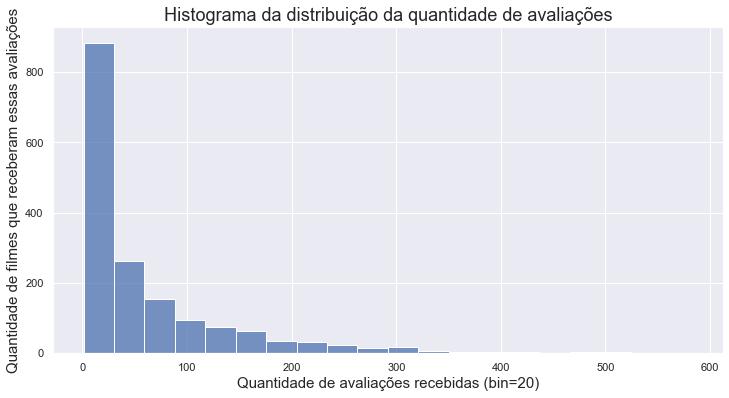

In [535]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['count'], bins=20)
plt.title('Histograma da distribuição da quantidade de avaliações', fontsize=18)
plt.xlabel('Quantidade de avaliações recebidas (bin=20)', fontsize=15)
plt.ylabel('Quantidade de filmes que receberam essas avaliações', fontsize=15)
plt.show()

Este gráfico é interessante, mostra a distribuição da quantidade de avaliações recebidas pelos filmes. A leitura é simples, no eixo X temos a quantidade de avaliações recebidas pelo filme, separadas por grupos de 20. Já no eixo Y temos a quantidade de filmes que receberam essa quantidade de avaliações mencionada no eixo X. Em outras palavras, temos que mais de 800 filmes receberam até 20 avaliações. Isso reflete da assimetria a direita na distribuição, ou seja, muitos filmes possuem poucas avaliações a poucos filmes recebem muitas avaliações.

#### Boxplot da quantidade de avaliações

Isso pode também ser confirmado pelo gráfico de boxplot, onde podemos notar que a linha preta no meio da pilha (mediana da quantidade de avaliações) está mais perto da primeira linha horizontal (1º quartil), e alguns outros outliers podem ser encontrados na parte superior (pontos pretos).

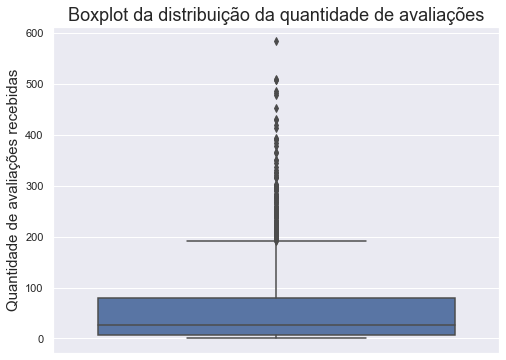

In [536]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'count', data = df_agrupado)
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### Histrograma da média de avaliações

Da mesma maneira pode ser interessante analisar a média das avaliações dadas pelos usuários, então:

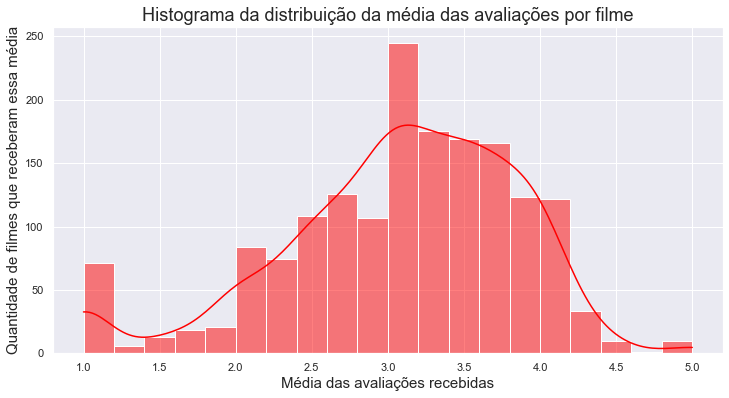

In [537]:
plt.figure(figsize=(12,6))
sns.histplot(df_agrupado['mean'], bins=20, kde=True, color='red')
plt.title('Histograma da distribuição da média das avaliações por filme', fontsize=18)
plt.ylabel('Quantidade de filmes que receberam essa média', fontsize=15)
plt.xlabel('Média das avaliações recebidas', fontsize=15)
plt.show()

#### Boxplot da média de avaliações

Tanto com o histograma acima, como com o boxplot abaixo podemos notar uma concentração maior das médias de avaliações dos filmes entre 2,5 e 3,7. Mas a mediana por volta dos 3,2. Há ainda uma quantidade boa de filmes que tenham recebido nota média inferior a 2 e poucos que tenham recebido nota média por volta do 5.

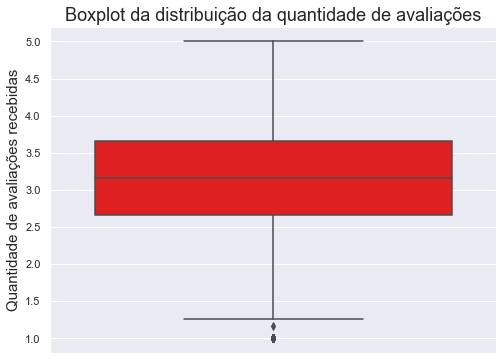

In [538]:
plt.figure(figsize=(8,6))
sns.boxplot(y = 'mean', data = df_agrupado, color='red')
plt.title('Boxplot da distribuição da quantidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

#### A relação entre média e quantidade de avaliações

Precisamente temos uma mediana geral de 27 avaliações por filme e uma nota médiana geral de 3,16.

In [539]:
df_agrupado.median()

id_filme    841.500000
count        27.000000
mean          3.161528
dtype: float64

Mas abrindo ainda mais esses números pelos filmes em sí, podemos enxergar...

In [540]:
#Criando um dataframe temporário para a análise em questão
df_agrupado = df_agrupado.reset_index().merge(df_item, left_on='id_filme', right_on='id_filme', how='left')

Top 10 filmes que mais receberam avaliações:

In [541]:
df_agrupado[['nome_filme','count']].sort_values(by='count', ascending=False).head(10)

,nome_filme,count
1128,Star Wars (1977),583
859,Contact (1997),509
2,Fargo (1996),508
774,Return of the Jedi (1983),507
899,Liar Liar (1997),485
890,"English Patient, The (1996)",481
892,Scream (1996),478
0,Toy Story (1995),452
907,Air Force One (1997),431
235,Independence Day (ID4) (1996),429


Top 10 filmes mais bem avaliados (com pelo menos 100 avaliações cada):

In [542]:
df_agrupado[df_agrupado['count'] > 50][['nome_filme','mean', 'count']].sort_values(by='mean', ascending=False).head(10)

,nome_filme,mean,count
1026,"Close Shave, A (1995)",4.491071,112
926,Schindler's List (1993),4.466443,298
760,"Wrong Trousers, The (1993)",4.466102,118
1109,Casablanca (1942),4.456790,243
157,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1283,"Shawshank Redemption, The (1994)",4.445230,283
1243,Rear Window (1954),4.387560,209
223,"Usual Suspects, The (1995)",4.385768,267
1128,Star Wars (1977),4.358491,583
770,12 Angry Men (1957),4.344000,125


Será que podemos dizer que os filmes mais avaliados, o que é uma proxy para talvez os filmes mais vistos, serem os filmes mais bem avaliados? De fato, apesar de existir alguma correlação entre quantidade e quantidade, ela é fraca. Precisamente de 0,4. Então nem sempre isso é verdade, apesar de em alguns casos podermos dizer que sim.

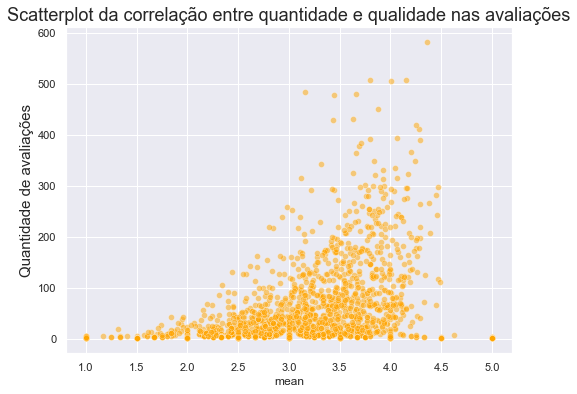

In [543]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='mean',y='count',data=df_agrupado,alpha=0.5, color='orange')
plt.title('Scatterplot da correlação entre quantidade e qualidade nas avaliações', fontsize=18)
plt.ylabel('Média das avaliações', fontsize=15)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.show()

In [547]:
#Os números de correlação exatos vieram daqui:
df_agrupado[['mean','count']].corr()

,mean,count
mean,1.000000,0.429659
count,0.429659,1.000000


#### Quais são os temas que mais receberam avaliações

Lembrando que um filme pode pertencer a mais de um tema, temos a seguinte análise a ser feita:

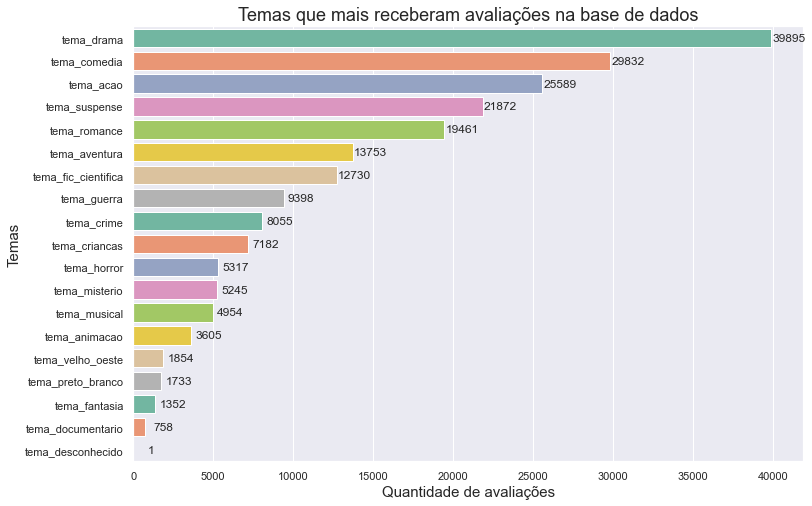

In [621]:
#Preparação do dado para a plotagem
cols = df_agrupado.columns[6:]
dict_cols = {coluna:0 for coluna in cols}

for i in df_agrupado.index:
    for coluna in cols:
        if (df_agrupado.iloc[i][coluna] == 1):
            dict_cols[coluna] += df_agrupado.iloc[i]['count']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,8))
plt.title('Temas que mais receberam avaliações na base de dados', fontsize=18)
plt.ylabel('Temas', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  palette="Set2")

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 1100, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

Temos que o Drama foi o tema que mais recebeu avaliações, seguido por comédia e ação.

#### Quantidade de filmes publicados por ano

Analisando a quantidade de filmes publicados por ano podemos ver que alguns filmes bem antigos estão sendo avaliados mesmo depois de varios anos, mas o pico nos ultimos 5 anos ainda é o que mais representa a base de dados.

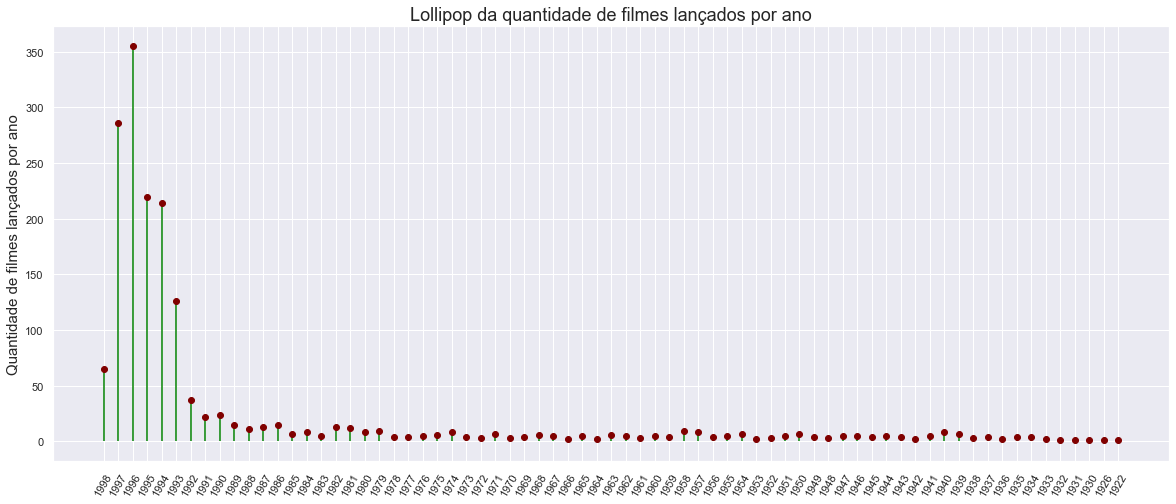

In [549]:
df_item['year'] = df_item['data_lancamento'].str[-4:]
g = df_item[['year','id_filme']].groupby(by='year').count().to_dict()
g = g['id_filme']
fig, ax = plt.subplots(figsize = (20, 8))

x=list(g.keys())[::-1]
y=list(g.values())[::-1]
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 60)
ax.set_ylabel("Quantidade de filmes lançados por ano", fontsize=15)
# set a title
ax.set_title("Lollipop da quantidade de filmes lançados por ano", fontsize=18)
plt.show()

#### Quantidade de avaliações por gênero

Analisando a quantidade de avaliações feitas por gênero temos que os homens tem maior presença na base de dados. Cerca de 2.9x mais avaliações.

In [552]:
df = df.merge(df_usuarios, left_on='id_usuario', right_on='id_usuario', how='left')

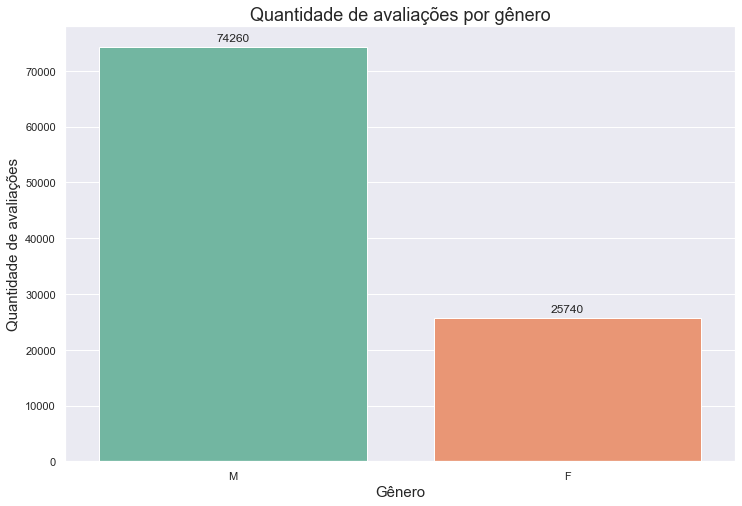

In [623]:
plt.figure()
ax = sns.countplot(x="sexo", data=df, palette="Set2")
sns.set(style="darkgrid", rc={'figure.figsize':(12,8)})
plt.title('Quantidade de avaliações por gênero', fontsize=18)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.xlabel('Gênero', fontsize=15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

#### Quantidade de avaliações por estado (EUA)

Analisando a quantidade de avaliações feitas por cada estado dos EUA na base. Temos que os Califórnia, Minnesota e Nova Iorque são os que tem maior presença na base de dados.

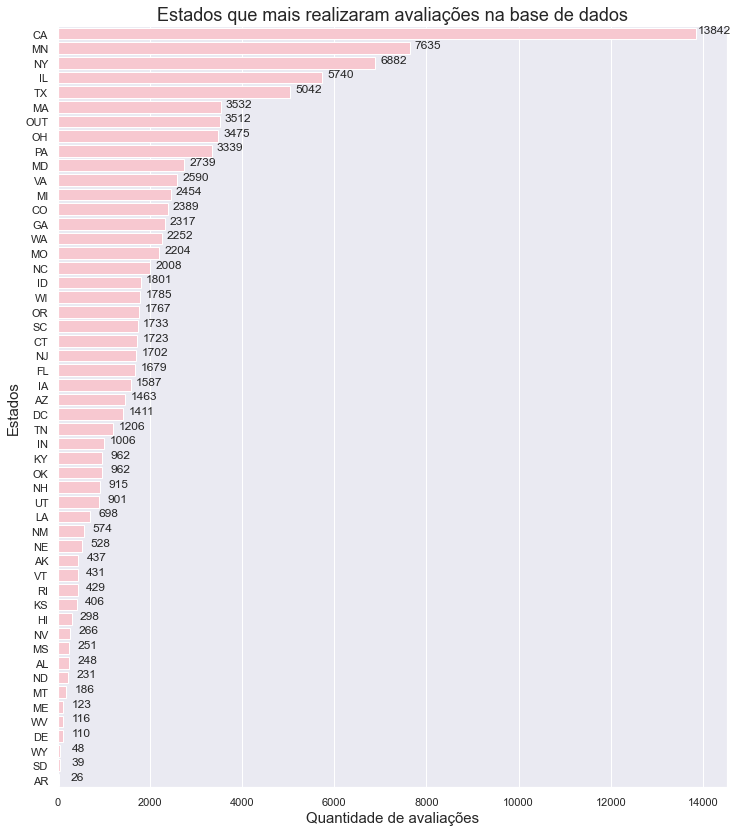

In [615]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='estado_usa').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Estados que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Estados', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  color='pink')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 400, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.show()

#### Quantidade de avaliações por profissão

Analisando a quantidade de avaliações feitas por cada profissão na base. Temos que os estudantes são os que tem maior presença na base de dados. Cerca de 2x mais avaliações que a segunda categoria.

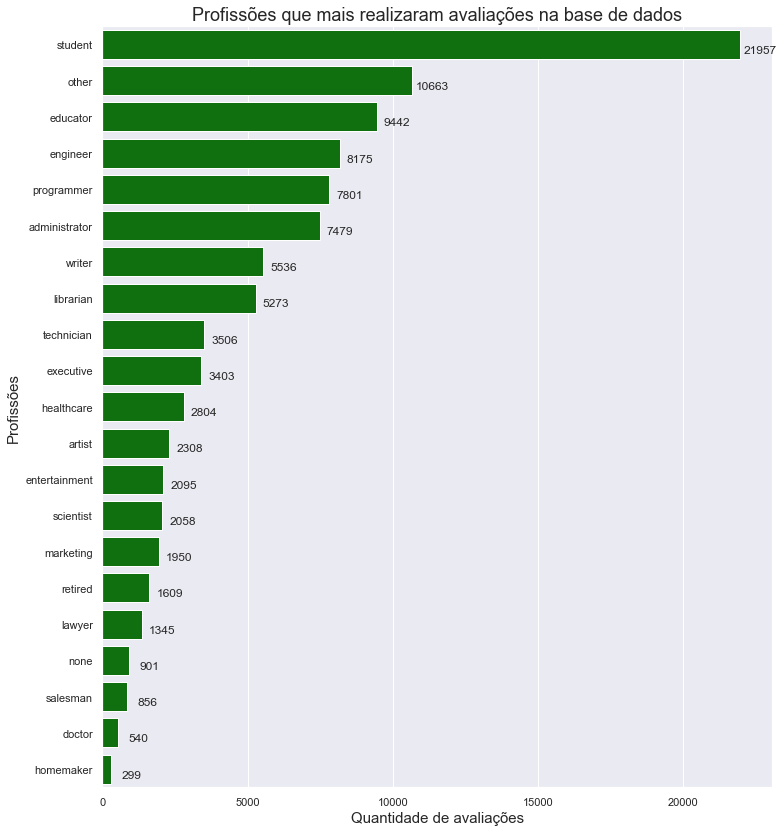

In [618]:
#Preparação do dado para a plotagem
dict_cols = df.groupby(by='profissao').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

#plotagem
plt.figure(figsize=(12,14))
plt.title('Profissões que mais realizaram avaliações na base de dados', fontsize=18)
plt.ylabel('Profissões', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style="darkgrid")
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()),  color='green')
    
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width() + 700, (p.get_height()) +  p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.show()